In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=24
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

90

(24, 256, 256, 3)
[1 0 2 0 0 2 0 0 1 1 0 0 2 1 0 1 1 0 0 0 2 1 1 0]


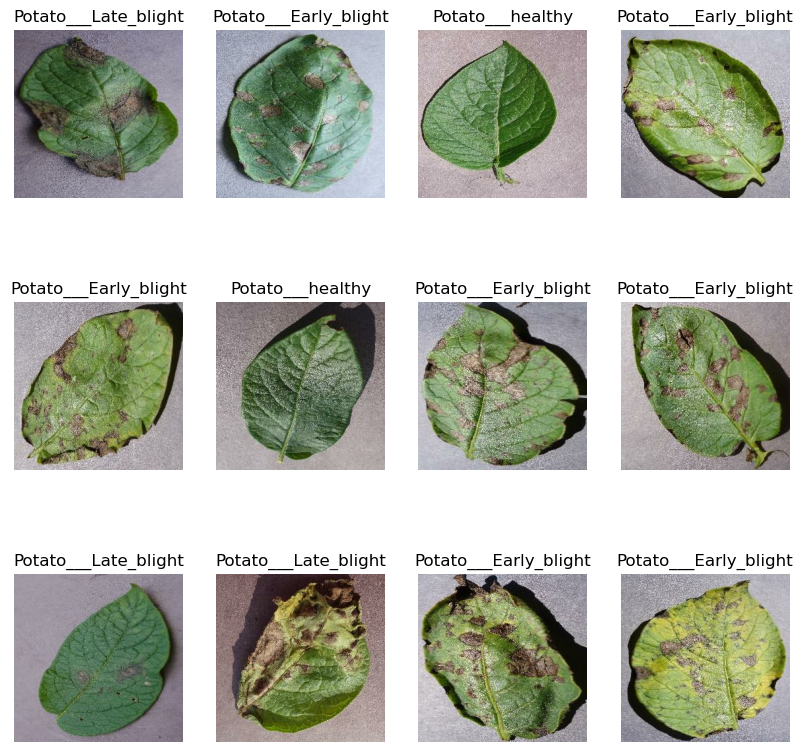

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

72 9 9


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (24, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (24, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (24, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (24, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (24, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (24, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
72/72 [==============================] - 73s 979ms/step - loss: 0.8657 - accuracy: 0.5064 - val_loss: 0.6601 - val_accuracy: 0.7037
Epoch 2/20
72/72 [==============================] - 70s 970ms/step - loss: 0.5221 - accuracy: 0.7367 - val_loss: 0.4318 - val_accuracy: 0.8426
Epoch 3/20
72/72 [==============================] - 71s 980ms/step - loss: 0.4276 - accuracy: 0.8142 - val_loss: 0.3780 - val_accuracy: 0.8287
Epoch 4/20
72/72 [==============================] - 71s 986ms/step - loss: 0.3173 - accuracy: 0.8640 - val_loss: 0.4502 - val_accuracy: 0.7917
Epoch 5/20
72/72 [==============================] - 92s 1s/step - loss: 0.2437 - accuracy: 0.9005 - val_loss: 0.2944 - val_accuracy: 0.8981
Epoch 6/20
72/72 [==============================] - 89s 1s/step - loss: 0.2055 - accuracy: 0.9219 - val_loss: 0.2962 - val_accuracy: 0.8981
Epoch 7/20
72/72 [==============================] - 86s 1s/step - loss: 0.1777 - accuracy: 0.9369 - val_loss: 0.2093 - val_accuracy: 0.9213
Epoch 8/

In [13]:
scores=model.evaluate(test_ds)
scores

9/9 [==============================] - 2s 168ms/step - loss: 0.0198 - accuracy: 0.9907


[0.019836299121379852, 0.9907407164573669]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8656931519508362,
 0.5220970511436462,
 0.42758533358573914,
 0.3173445165157318,
 0.24372375011444092,
 0.20550765097141266,
 0.1776944398880005,
 0.16871842741966248,
 0.18367134034633636,
 0.17868612706661224,
 0.12192969024181366,
 0.11220021545886993,
 0.08874362707138062,
 0.11612504720687866,
 0.07021746039390564,
 0.06758086383342743,
 0.044137854129076004,
 0.047241780906915665,
 0.06720878183841705,
 0.022281479090452194]

In [16]:
history.history['accuracy']

[0.5063657164573669,
 0.7366898059844971,
 0.8142361044883728,
 0.8640046119689941,
 0.9004629850387573,
 0.921875,
 0.9369212985038757,
 0.9357638955116272,
 0.9305555820465088,
 0.9357638955116272,
 0.9571759104728699,
 0.9629629850387573,
 0.9699074029922485,
 0.9560185074806213,
 0.9745370149612427,
 0.9762731194496155,
 0.9832175970077515,
 0.9820601940155029,
 0.9710648059844971,
 0.9959490895271301]

In [17]:
history.history['val_loss']

[0.660061776638031,
 0.43184491991996765,
 0.3779641389846802,
 0.45017561316490173,
 0.2944071590900421,
 0.296223521232605,
 0.2093469500541687,
 0.3860856592655182,
 0.24604977667331696,
 0.2534877359867096,
 0.16931991279125214,
 0.14539514482021332,
 0.17959845066070557,
 0.18344071507453918,
 0.06614814698696136,
 0.09998443722724915,
 0.13184140622615814,
 0.0504453182220459,
 0.06257323175668716,
 0.02223193272948265]

In [18]:
history.history['val_accuracy']

[0.7037037014961243,
 0.8425925970077515,
 0.8287037014961243,
 0.7916666865348816,
 0.8981481194496155,
 0.8981481194496155,
 0.9212962985038757,
 0.9027777910232544,
 0.9027777910232544,
 0.9074074029922485,
 0.9259259104728699,
 0.9444444179534912,
 0.9444444179534912,
 0.9398148059844971,
 0.9722222089767456,
 0.9722222089767456,
 0.9629629850387573,
 0.9768518805503845,
 0.9722222089767456,
 0.9953703880310059]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

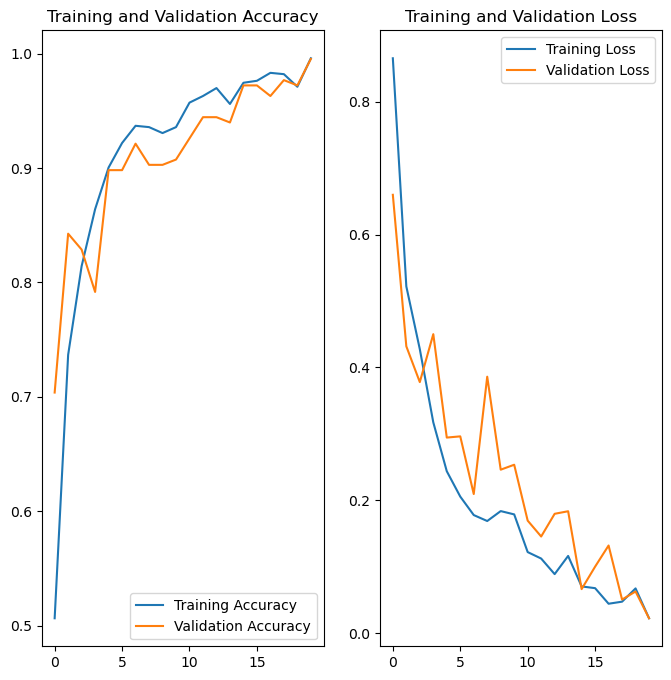

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(9):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 211ms/step


In [23]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


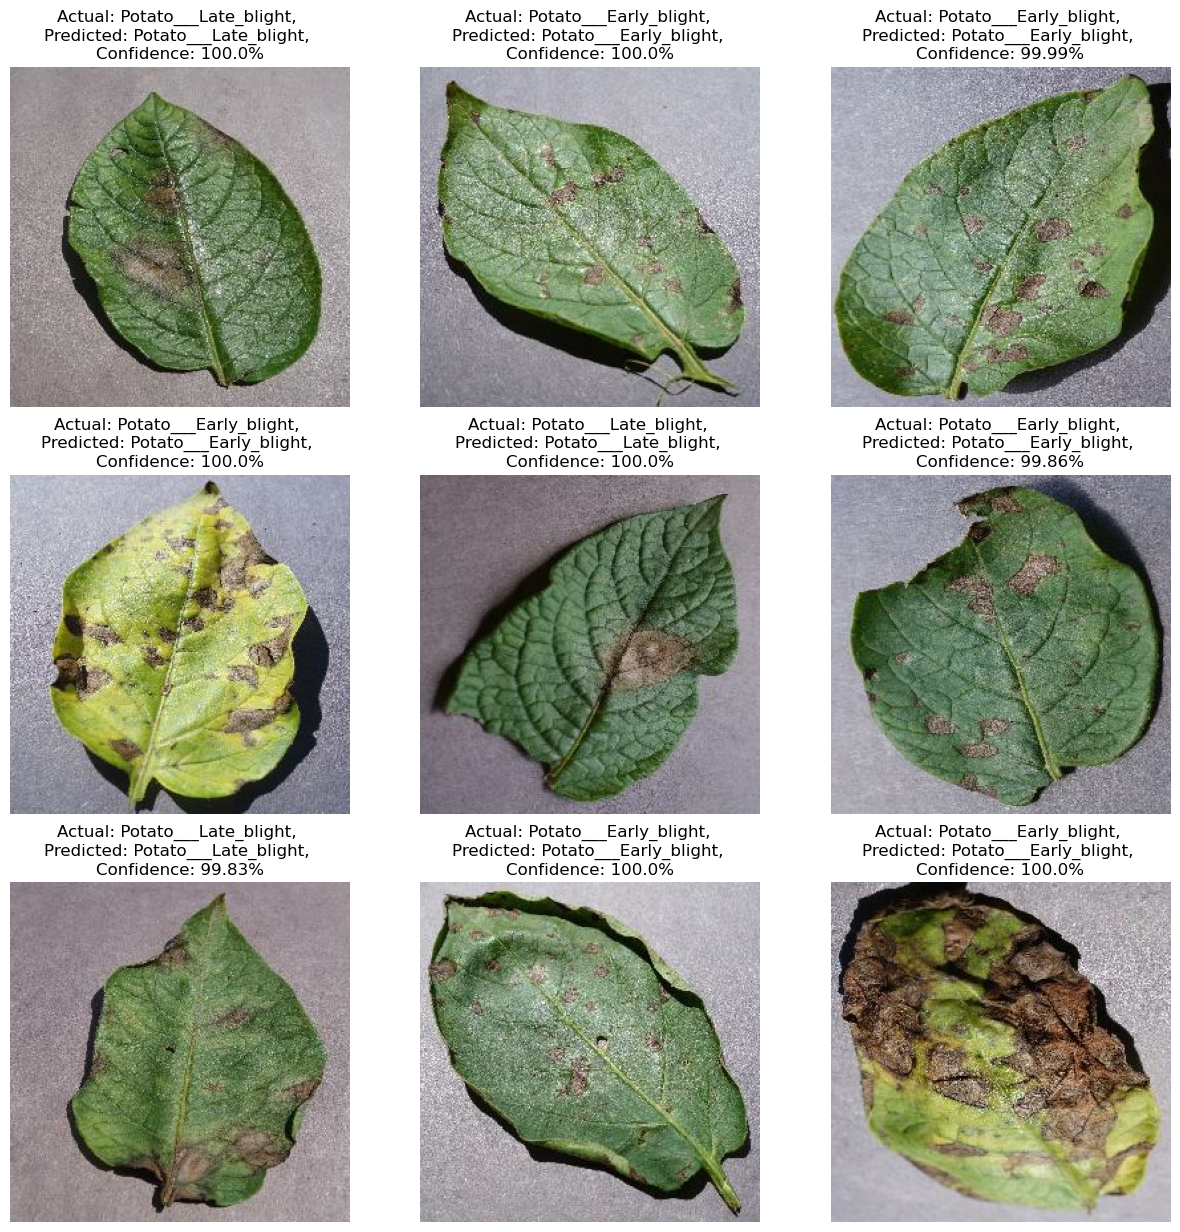

In [24]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [25]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       112
           1       0.99      0.99      0.99        94
           2       1.00      0.90      0.95        10

    accuracy                           0.99       216
   macro avg       0.99      0.96      0.98       216
weighted avg       0.99      0.99      0.99       216



In [26]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[112,   0,   0],
       [  1,  93,   0],
       [  0,   1,   9]])>

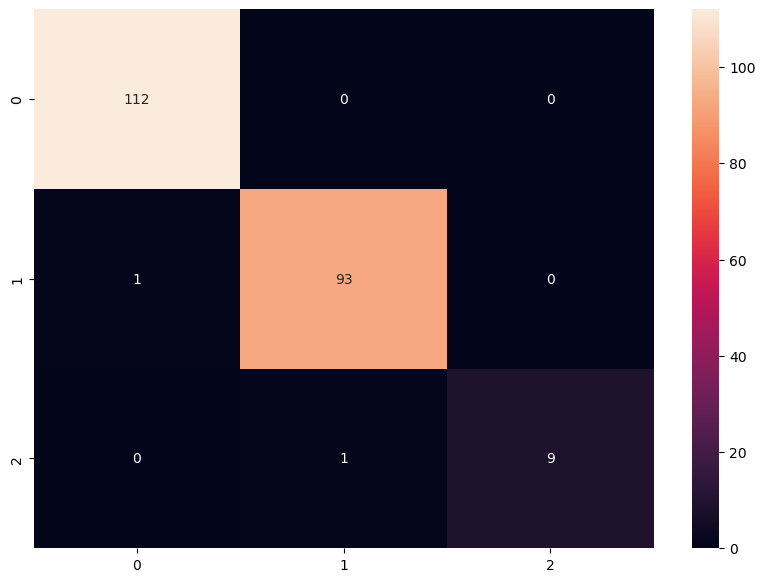

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-BatchSize24.joblib"
joblib.dump(model, filename)

['Model1-BatchSize24.joblib']